In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pickle
import json
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

TensorFlow Version: 2.18.0
Keras Version: 3.5.0


In [15]:
def load_and_prepare_data(base_path="Malaria Dataset/", sample_size=None):
    """
    Load and preprocess malaria dataset with proper error handling
    """
    def load_images_from_folder(folder_path, label, sample_size=None):
        images = []
        labels = []
        class_path = os.path.join(folder_path, label)
        
        if not os.path.exists(class_path):
            print(f"Warning: Path {class_path} does not exist")
            return images, labels
        
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        if sample_size:
            image_files = image_files[:sample_size]
        
        print(f"Loading {len(image_files)} {label} images...")
        
        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize to 224x224 and normalize
                    img = cv2.resize(img, (224, 224))
                    img = img.astype('float32') / 255.0
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Could not read {img_path}")
            except Exception as e:
                print(f"Error reading {img_path}: {e}")
        
        return images, labels
    
    # Define paths
    train_path = os.path.join(base_path, "train")
    test_path = os.path.join(base_path, "test")
    val_path = os.path.join(base_path, "val")
    
    # Check if paths exist
    for path in [train_path, test_path, val_path]:
        if not os.path.exists(path):
            print(f"Error: {path} does not exist!")
            return None, None, None, None, None, None
    
    print("="*50)
    print("Loading Training Data...")
    print("="*50)
    
    # Load training data
    parasitized_train, labels_p_train = load_images_from_folder(train_path, "Parasitized", sample_size)
    uninfected_train, labels_u_train = load_images_from_folder(train_path, "Uninfected", sample_size)
    
    X_train = np.array(parasitized_train + uninfected_train)
    y_train = np.array(labels_p_train + labels_u_train)
    
    print("\n" + "="*50)
    print("Loading Test Data...")
    print("="*50)
    
    # Load test data
    parasitized_test, labels_p_test = load_images_from_folder(test_path, "Parasitized", sample_size)
    uninfected_test, labels_u_test = load_images_from_folder(test_path, "Uninfected", sample_size)
    
    X_test = np.array(parasitized_test + uninfected_test)
    y_test = np.array(labels_p_test + labels_u_test)
    
    print("\n" + "="*50)
    print("Loading Validation Data...")
    print("="*50)
    
    # Load validation data
    parasitized_val, labels_p_val = load_images_from_folder(val_path, "Parasitized", sample_size)
    uninfected_val, labels_u_val = load_images_from_folder(val_path, "Uninfected", sample_size)
    
    X_val = np.array(parasitized_val + uninfected_val)
    y_val = np.array(labels_p_val + labels_u_val)
    
    print("\n" + "="*50)
    print("Data Loading Complete!")
    print("="*50)
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    
    return X_train, y_train, X_test, y_test, X_val, y_val

# Load data (adjust sample_size for faster testing)
X_train, y_train, X_test, y_test, X_val, y_val = load_and_prepare_data(
    base_path="Malaria Dataset/", 
    sample_size=500  # Adjust as needed (None for all data)
)

Loading Training Data...
Loading 500 Parasitized images...


100%|██████████| 500/500 [00:00<00:00, 610.25it/s]


Loading 500 Uninfected images...


100%|██████████| 500/500 [00:00<00:00, 675.27it/s]



Loading Test Data...
Loading 500 Parasitized images...


100%|██████████| 500/500 [00:00<00:00, 653.57it/s]


Loading 500 Uninfected images...


100%|██████████| 500/500 [00:00<00:00, 647.73it/s]



Loading Validation Data...
Loading 500 Parasitized images...


100%|██████████| 500/500 [00:05<00:00, 92.42it/s]


Loading 500 Uninfected images...


100%|██████████| 500/500 [00:05<00:00, 87.25it/s] 



Data Loading Complete!
X_train shape: (1000, 224, 224, 3)
y_train shape: (1000,)
X_test shape: (1000, 224, 224, 3)
y_test shape: (1000,)
X_val shape: (1000, 224, 224, 3)
y_val shape: (1000,)


Dataset Statistics:
------------------------------
Training samples: 1000
Test samples: 1000
Validation samples: 1000
Total samples: 3000

Class Distribution:
------------------------------
Training: Parasitized=500, Uninfected=500
Test: Parasitized=500, Uninfected=500
Validation: Parasitized=500, Uninfected=500


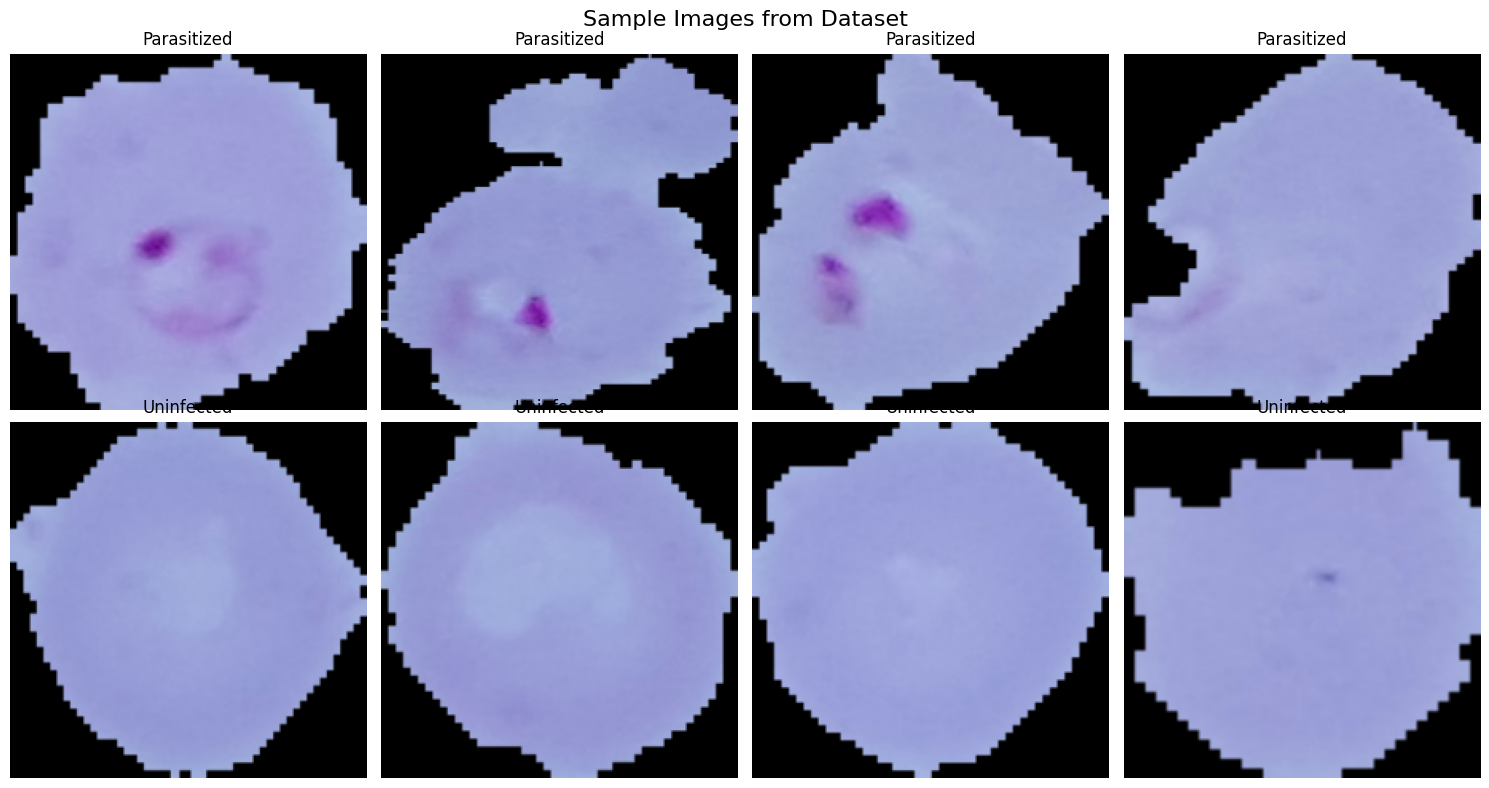

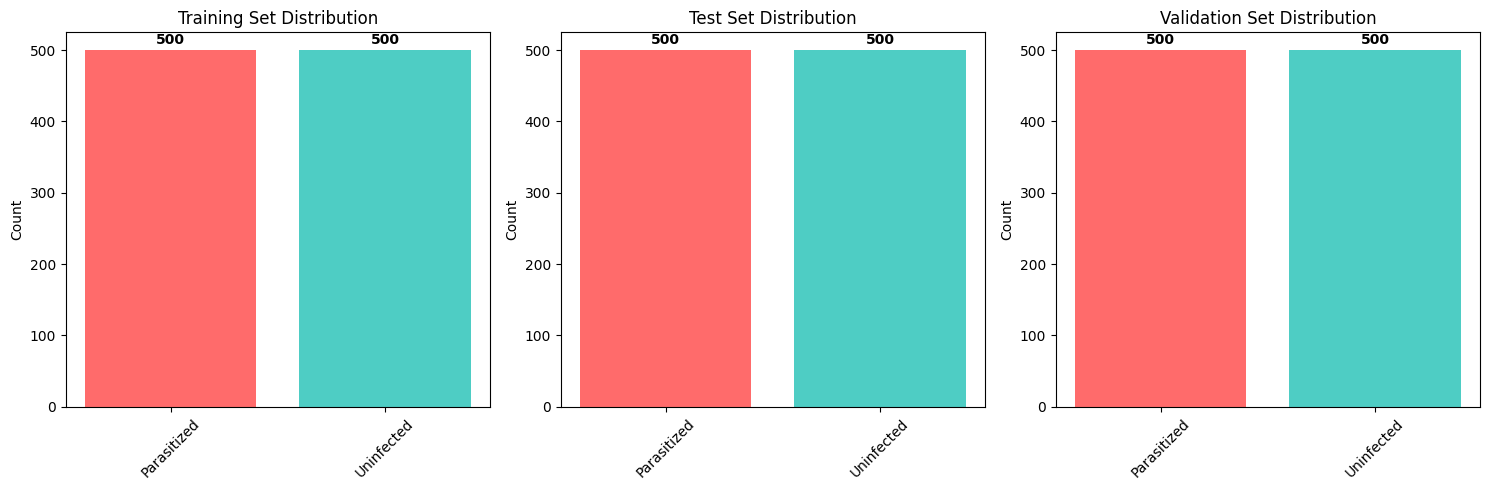

In [16]:
def explore_data(X_train, y_train, X_test, y_test, X_val, y_val):
    """
    Visualize and explore the dataset
    """
    # Print dataset statistics
    print("Dataset Statistics:")
    print("-" * 30)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Total samples: {len(X_train) + len(X_test) + len(X_val)}")
    
    # Class distribution
    print("\nClass Distribution:")
    print("-" * 30)
    for split_name, labels in [("Training", y_train), ("Test", y_test), ("Validation", y_val)]:
        parasitized = np.sum(labels == "Parasitized")
        uninfected = np.sum(labels == "Uninfected")
        print(f"{split_name}: Parasitized={parasitized}, Uninfected={uninfected}")
    
    # Visualize sample images
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    # Display parasitized images
    parasitized_indices = np.where(y_train == "Parasitized")[0][:4]
    for i, idx in enumerate(parasitized_indices):
        axes[i].imshow(X_train[idx])
        axes[i].set_title("Parasitized")
        axes[i].axis('off')
    
    # Display uninfected images
    uninfected_indices = np.where(y_train == "Uninfected")[0][:4]
    for i, idx in enumerate(uninfected_indices):
        axes[i+4].imshow(X_train[idx])
        axes[i+4].set_title("Uninfected")
        axes[i+4].axis('off')
    
    plt.suptitle("Sample Images from Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Plot class distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    splits = [("Training", y_train), ("Test", y_test), ("Validation", y_val)]
    colors = ['#FF6B6B', '#4ECDC4']
    
    for idx, (name, labels) in enumerate(splits):
        parasitized = np.sum(labels == "Parasitized")
        uninfected = np.sum(labels == "Uninfected")
        
        axes[idx].bar(['Parasitized', 'Uninfected'], [parasitized, uninfected], color=colors)
        axes[idx].set_title(f'{name} Set Distribution')
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, v in enumerate([parasitized, uninfected]):
            axes[idx].text(i, v + max([parasitized, uninfected])*0.01, str(v), 
                          ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Explore the data
explore_data(X_train, y_train, X_test, y_test, X_val, y_val)

In [17]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # 0=Uninfected, 1=Parasitized
y_test_encoded = le.transform(y_test)
y_val_encoded = le.transform(y_val)

# Convert to categorical for multi-class (though we have binary classification)
y_train_categorical = to_categorical(y_train_encoded, num_classes=2)
y_test_categorical = to_categorical(y_test_encoded, num_classes=2)
y_val_categorical = to_categorical(y_val_encoded, num_classes=2)

print("Label encoding complete:")
print(f"Original labels: {y_train[:5]}")
print(f"Encoded labels: {y_train_encoded[:5]}")
print(f"Categorical labels (first 5):\n{y_train_categorical[:5]}")

# Create data generators for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescale for validation and test
val_datagen = ImageDataGenerator()

# Create data generators
batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train_categorical,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val_categorical,
    batch_size=batch_size,
    shuffle=False
)

test_generator = val_datagen.flow(
    X_test, y_test_categorical,
    batch_size=batch_size,
    shuffle=False
)

print(f"\nData generators created:")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")
print(f"Test batches: {len(test_generator)}")

Label encoding complete:
Original labels: ['Parasitized' 'Parasitized' 'Parasitized' 'Parasitized' 'Parasitized']
Encoded labels: [0 0 0 0 0]
Categorical labels (first 5):
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]

Data generators created:
Training batches per epoch: 32
Validation batches: 32
Test batches: 32


In [18]:
def create_cnn_model(input_shape=(224, 224, 3)):
    """Basic CNN Model"""
    model = models.Sequential([
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

def create_vgg16_model(input_shape=(224, 224, 3)):
    """VGG16 Transfer Learning Model"""
    # Load pre-trained VGG16
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

def create_resnet50_model(input_shape=(224, 224, 3)):
    """ResNet50 Transfer Learning Model"""
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

def create_mobilenet_model(input_shape=(224, 224, 3)):
    """MobileNetV2 Transfer Learning Model"""
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

# Create models
print("Creating models...")
models_dict = {
    'CNN': create_cnn_model(),
    'VGG16': create_vgg16_model(),
    'ResNet50': create_resnet50_model(),
    'MobileNetV2': create_mobilenet_model()
}

# Display model summaries
for name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"{name} Model Summary")
    print('='*60)
    model.summary()
    print(f"Total parameters: {model.count_params():,}")

Creating models...

CNN Model Summary


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,804,450 (197.62 MB)

 Trainable params: 51,802,018 (197.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

Total parameters: 51,804,450

VGG16 Model Summary


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,706 (56.77 MB)

 Trainable params: 165,250 (645.51 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

Total parameters: 14,880,706

ResNet50 Model Summary


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,946 (92.11 MB)

 Trainable params: 558,466 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

Total parameters: 24,146,946

MobileNetV2 Model Summary


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,610 (10.00 MB)

 Trainable params: 361,858 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

Total parameters: 2,620,610


In [22]:
def train_model(model, model_name, train_generator, val_generator, epochs=30):
    """Train a single model with callbacks"""
    # Create callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name}.keras',  # Changed from .h5 to .keras
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=0
        )
    ]
    
    print(f"\n{'='*60}")
    print(f"Training {model_name} model...")
    print('='*60)
    
    # Calculate steps per epoch
    steps_per_epoch = len(train_generator)
    validation_steps = len(val_generator)
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Train all models
history_dict = {}
epochs = 5  # Adjust as needed

for name, model in models_dict.items():
    history = train_model(model, name, train_generator, val_generator, epochs)
    history_dict[name] = history


Training CNN model...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.5047 - loss: 0.6932 - precision: 0.5047 - recall: 0.5047 - val_accuracy: 0.5000 - val_loss: 0.7032 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.4986 - loss: 0.6931 - precision: 0.4986 - recall: 0.4986 - val_accuracy: 0.5000 - val_loss: 0.8435 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.4962 - loss: 0.6932 - precision: 0.4962 - recall: 0.4962 - val_accuracy: 0.5000 - val_loss: 2.0711 - val_precis

In [23]:
def evaluate_model(model, model_name, test_generator):
    """Evaluate model on test set"""
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name} model...")
    print('='*60)
    
    # Evaluate on test set
    results = model.evaluate(test_generator, verbose=0)
    
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Precision: {results[2]:.4f}")
    print(f"Test Recall: {results[3]:.4f}")
    
    # Make predictions
    y_pred_proba = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Get true labels
    y_true = []
    for i in range(len(test_generator)):
        _, batch_labels = test_generator[i]
        y_true.extend(np.argmax(batch_labels, axis=1))
        if (i+1) * batch_size >= len(X_test):
            break
    
    y_true = np.array(y_true)[:len(y_pred)]
    
    return results, y_true, y_pred, y_pred_proba

# Evaluate all models
model_results = {}
for name, model in models_dict.items():
    results, y_true, y_pred, y_pred_proba = evaluate_model(model, name, test_generator)
    model_results[name] = {
        'results': results,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }


Evaluating CNN model...
Test Loss: 0.7020
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 0.5000

Evaluating VGG16 model...
Test Loss: 0.7154
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 0.5000

Evaluating ResNet50 model...
Test Loss: 0.7204
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 0.5000

Evaluating MobileNetV2 model...
Test Loss: 0.8772
Test Accuracy: 0.5090
Test Precision: 0.5090
Test Recall: 0.5090


Generating visualizations...


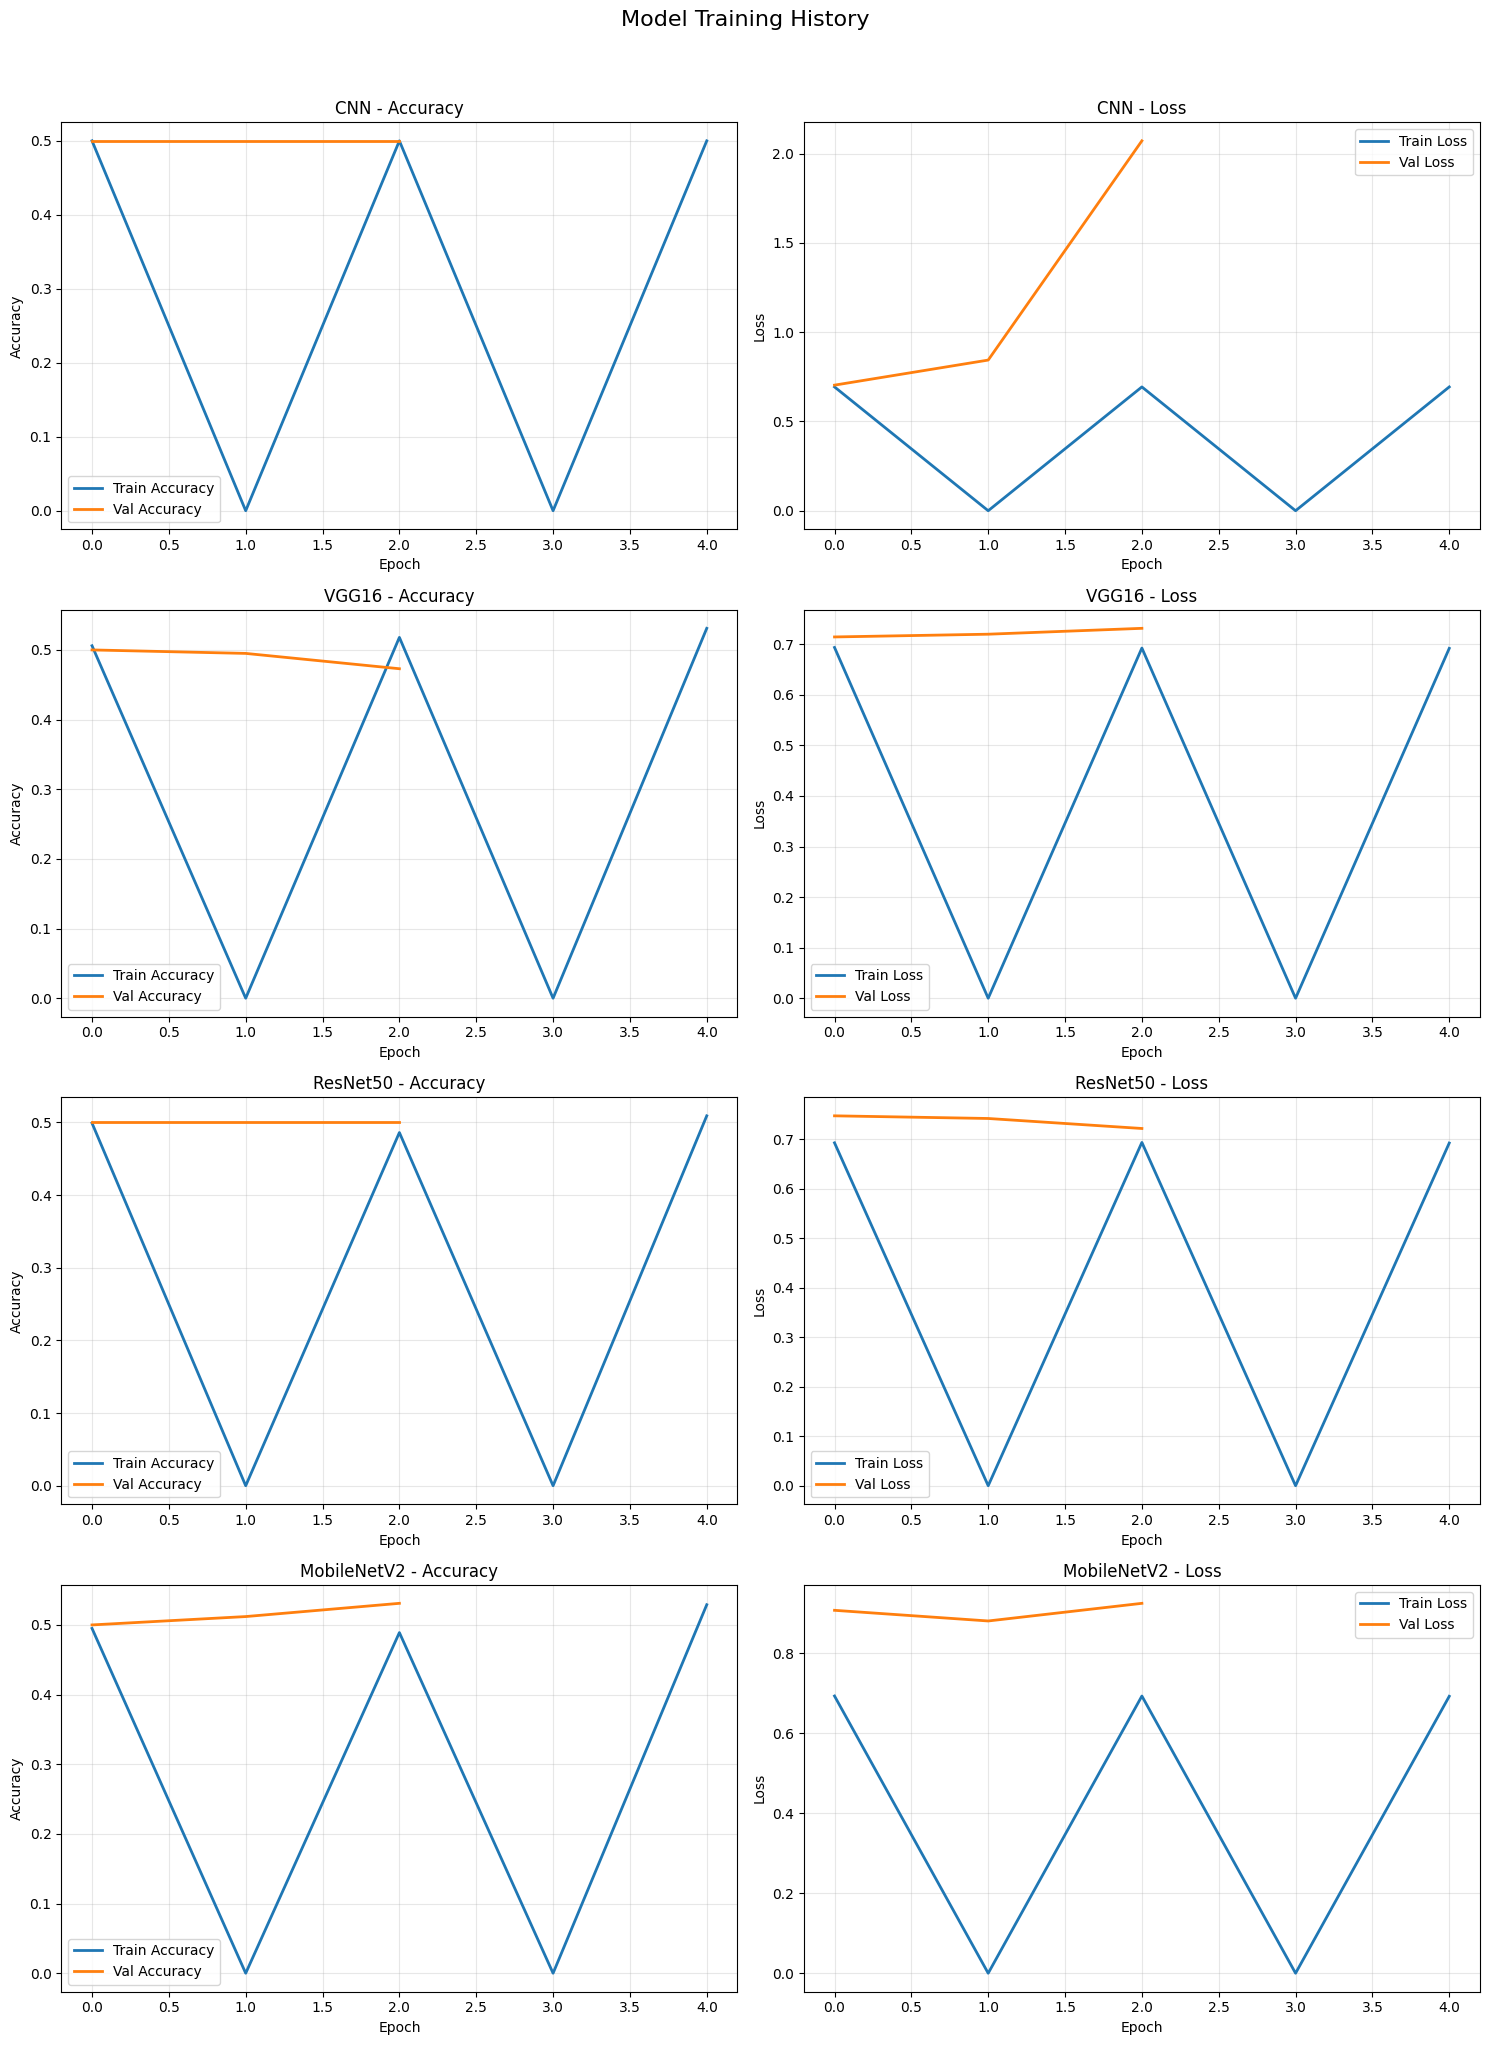

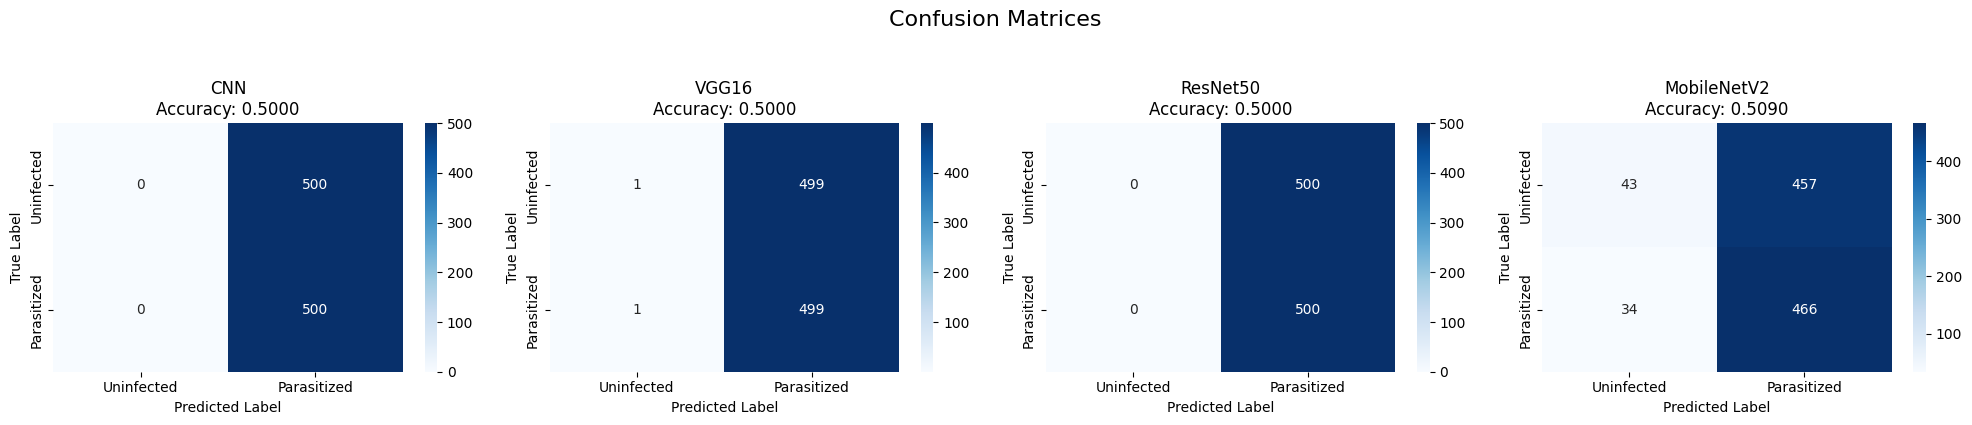

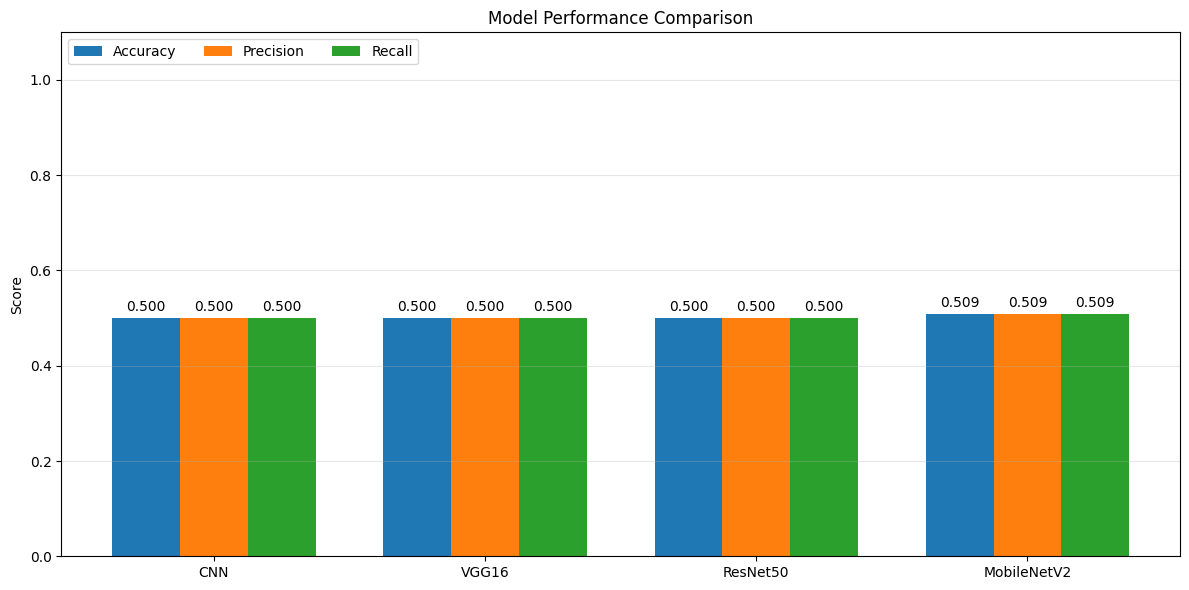

In [25]:
def plot_training_history(history_dict):
    """Plot training history for all models"""
    n_models = len(history_dict)
    fig, axes = plt.subplots(n_models, 2, figsize=(15, 5*n_models))
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (name, history) in enumerate(history_dict.items()):
        # Plot accuracy
        axes[idx, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[idx, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        axes[idx, 0].set_title(f'{name} - Accuracy')
        axes[idx, 0].set_xlabel('Epoch')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Plot loss
        axes[idx, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
        axes[idx, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        axes[idx, 1].set_title(f'{name} - Loss')
        axes[idx, 1].set_xlabel('Epoch')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Model Training History', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(model_results):
    """Plot confusion matrices for all models"""
    n_models = len(model_results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (name, results) in enumerate(model_results.items()):
        cm = confusion_matrix(results['y_true'], results['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Uninfected', 'Parasitized'],
                   yticklabels=['Uninfected', 'Parasitized'],
                   ax=axes[idx])
        axes[idx].set_title(f'{name}\nAccuracy: {results["results"][1]:.4f}')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
    
    plt.suptitle('Confusion Matrices', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

def plot_model_comparison(model_results):
    """Compare model performances"""
    metrics = ['Accuracy', 'Precision', 'Recall']
    model_names = list(model_results.keys())
    
    values = {
        'Accuracy': [results['results'][1] for results in model_results.values()],
        'Precision': [results['results'][2] for results in model_results.values()],
        'Recall': [results['results'][3] for results in model_results.values()]
    }
    
    x = np.arange(len(model_names))
    width = 0.25
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for metric, measurement in values.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=metric)
        ax.bar_label(rects, padding=3, fmt='%.3f')
        multiplier += 1
    
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width, model_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
print("Generating visualizations...")
plot_training_history(history_dict)
plot_confusion_matrices(model_results)
plot_model_comparison(model_results)

In [26]:
def predict_malaria(model, image_path, threshold=0.5):
    """
    Predict malaria from a single image
    """
    # Check if file exists
    if not os.path.exists(image_path):
        return {"error": f"File not found: {image_path}"}
    
    # Load and preprocess image
    try:
        img = cv2.imread(image_path)
        if img is None:
            return {"error": f"Could not read image: {image_path}"}
        
        # Resize to match model input
        img = cv2.resize(img, (224, 224))
        
        # Convert BGR to RGB if needed
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Normalize
        img = img.astype('float32') / 255.0
        
        # Add batch dimension
        img = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img, verbose=0)
        
        # Get probabilities
        uninfected_prob = prediction[0][0]
        parasitized_prob = prediction[0][1]
        
        # Determine result
        if parasitized_prob >= threshold:
            result = "Parasitized"
            confidence = parasitized_prob
        else:
            result = "Uninfected"
            confidence = uninfected_prob
        
        return {
            "result": result,
            "confidence": float(confidence),
            "probabilities": {
                "uninfected": float(uninfected_prob),
                "parasitized": float(parasitized_prob)
            }
        }
        
    except Exception as e:
        return {"error": f"Prediction error: {str(e)}"}

# Test prediction with sample
def test_prediction():
    """Test prediction with a sample image"""
    # Get a sample image from the dataset
    sample_idx = 0
    sample_image = X_test[sample_idx]
    true_label = "Parasitized" if y_test_encoded[sample_idx] == 1 else "Uninfected"
    
    # Save sample image temporarily
    temp_path = "temp_sample.jpg"
    cv2.imwrite(temp_path, (sample_image * 255).astype('uint8'))
    
    print("Testing prediction on sample image...")
    print(f"True label: {true_label}")
    
    # Test with each model
    for name, model in models_dict.items():
        result = predict_malaria(model, temp_path)
        if "error" not in result:
            print(f"\n{name}:")
            print(f"  Prediction: {result['result']}")
            print(f"  Confidence: {result['confidence']:.2%}")
            print(f"  Probabilities - Uninfected: {result['probabilities']['uninfected']:.4f}, "
                  f"Parasitized: {result['probabilities']['parasitized']:.4f}")
    
    # Clean up
    if os.path.exists(temp_path):
        os.remove(temp_path)

# Run prediction test
test_prediction()

Testing prediction on sample image...
True label: Uninfected

CNN:
  Prediction: Parasitized
  Confidence: 60.00%
  Probabilities - Uninfected: 0.4000, Parasitized: 0.6000

VGG16:
  Prediction: Parasitized
  Confidence: 57.83%
  Probabilities - Uninfected: 0.4217, Parasitized: 0.5783

ResNet50:
  Prediction: Parasitized
  Confidence: 65.05%
  Probabilities - Uninfected: 0.3495, Parasitized: 0.6505

MobileNetV2:
  Prediction: Parasitized
  Confidence: 51.52%
  Probabilities - Uninfected: 0.4848, Parasitized: 0.5152


In [31]:
from datetime import datetime  # Add this import at the top

def save_models_and_results(models_dict, model_results, le):
    """Save all models, results, and metadata - Simplified version"""
    print("\n" + "="*60)
    print("Saving models and results...")
    print("="*60)
    
    # Create directories
    os.makedirs("saved_models", exist_ok=True)
    os.makedirs("pickle_files", exist_ok=True)
    
    # Save each model in multiple formats
    for name, model in models_dict.items():
        print(f"\nSaving {name} model...")
        
        # 1. Save as .keras file (works in all recent TF versions)
        model.save(f"saved_models/{name}_model.keras")
        
        # 2. Save weights with .weights.h5 extension (always safe)
        model.save_weights(f"saved_models/{name}.weights.h5")
        
        # 3. Save architecture as JSON
        model_json = model.to_json()
        with open(f"saved_models/{name}_architecture.json", "w") as json_file:
            json_file.write(model_json)
        
        # 4. Save as pickle (custom object)
        model_data = {
            'model_name': name,
            'model_architecture': model.to_json(),
            'model_weights': model.get_weights(),
            'input_shape': model.input_shape,
            'output_shape': model.output_shape,
            'compile_config': model.get_compile_config(),
            'timestamp': datetime.now().isoformat()  # Now this works
        }
        
        with open(f"pickle_files/{name}_model.pkl", 'wb') as f:
            pickle.dump(model_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print(f"  ✓ Saved {name} model")
    
    # Save label encoder
    with open('pickle_files/label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)
    
    # Save model results
    results_summary = {}
    for name, results in model_results.items():
        results_summary[name] = {
            'test_accuracy': float(results['results'][1]),
            'test_precision': float(results['results'][2]),
            'test_recall': float(results['results'][3]),
            'test_loss': float(results['results'][0]),
            'confusion_matrix': confusion_matrix(results['y_true'], results['y_pred']).tolist()
        }
    
    with open('pickle_files/model_results.pkl', 'wb') as f:
        pickle.dump(results_summary, f)
    
    # Save training history
    history_summary = {}
    for name, history in history_dict.items():
        history_summary[name] = {
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss']
        }
    
    with open('pickle_files/training_history.pkl', 'wb') as f:
        pickle.dump(history_summary, f)
    
    # Save metadata
    metadata = {
        'dataset_info': {
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'val_samples': len(X_val),
            'image_shape': X_train[0].shape,
            'classes': ['Uninfected', 'Parasitized']
        },
        'training_info': {
            'batch_size': batch_size,
            'epochs': epochs,
            'models_trained': list(models_dict.keys()),
            'timestamp': datetime.now().isoformat()  # Fixed here too
        }
    }
    
    with open('pickle_files/metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    
    # Also save as JSON for readability
    with open('saved_models/metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("\n" + "="*60)
    print("All models and results saved successfully!")
    print("="*60)

# Save everything
save_models_and_results(models_dict, model_results, le)


Saving models and results...

Saving CNN model...
  ✓ Saved CNN model

Saving VGG16 model...
  ✓ Saved VGG16 model

Saving ResNet50 model...
  ✓ Saved ResNet50 model

Saving MobileNetV2 model...
  ✓ Saved MobileNetV2 model

All models and results saved successfully!


In [33]:
def load_model_from_pickle(pickle_path):
    """Load a model from pickle file with robust error handling"""
    try:
        with open(pickle_path, 'rb') as f:
            model_data = pickle.load(f)
        
        print(f"Loading {model_data.get('model_name', 'Unknown')} model from pickle...")
        
        # Reconstruct model from JSON
        model = models.model_from_json(model_data['model_architecture'])
        
        # Set weights
        model.set_weights(model_data['model_weights'])
        
        # Recompile model with robust error handling
        compile_config = model_data.get('compile_config', {})
        
        if compile_config:
            try:
                # Try to get optimizer config
                if 'optimizer' in compile_config:
                    optimizer_config = compile_config['optimizer']
                    # Check if it's a dict with 'config' key (common in TF)
                    if isinstance(optimizer_config, dict) and 'config' in optimizer_config:
                        optimizer = Adam.from_config(optimizer_config['config'])
                    else:
                        optimizer = Adam.from_config(optimizer_config)
                else:
                    optimizer = Adam(learning_rate=0.0001)  # Default
                
                # Get loss and metrics
                loss = compile_config.get('loss', 'categorical_crossentropy')
                metrics = compile_config.get('metrics', ['accuracy'])
                
                model.compile(
                    optimizer=optimizer,
                    loss=loss,
                    metrics=metrics
                )
                
            except Exception as e:
                print(f"Warning: Could not restore original compile config: {e}")
                print("Using default compilation settings...")
                model.compile(
                    optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
        else:
            # Default compilation if no config found
            model.compile(
                optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
        
        print(f"✓ Successfully loaded {model_data.get('model_name', 'Unknown')} model")
        print(f"  Input shape: {model.input_shape}")
        print(f"  Output shape: {model.output_shape}")
        print(f"  Number of layers: {len(model.layers)}")
        print(f"  Total parameters: {model.count_params():,}")
        
        return model
        
    except FileNotFoundError:
        print(f"Error: Pickle file not found at {pickle_path}")
        return None
    except Exception as e:
        print(f"Error loading model from pickle: {e}")
        print("\nTroubleshooting steps:")
        print("1. Check if the pickle file exists")
        print("2. Verify the pickle file is not corrupted")
        print("3. Check TensorFlow/Keras version compatibility")
        return None


def load_all_models_from_pickle(pickle_dir="pickle_files"):
    """Load all models from pickle files in a directory"""
    import glob
    
    if not os.path.exists(pickle_dir):
        print(f"Directory {pickle_dir} does not exist!")
        return {}
    
    # Find all model pickle files
    model_files = glob.glob(os.path.join(pickle_dir, "*_model.pkl"))
    
    if not model_files:
        print(f"No model pickle files found in {pickle_dir}")
        print("Available files:", os.listdir(pickle_dir))
        return {}
    
    print(f"Found {len(model_files)} model pickle files")
    
    loaded_models = {}
    
    for model_file in model_files:
        model_name = os.path.basename(model_file).replace('_model.pkl', '')
        print(f"\n{'='*50}")
        print(f"Attempting to load: {model_name}")
        print('='*50)
        
        model = load_model_from_pickle(model_file)
        if model is not None:
            loaded_models[model_name] = model
    
    print(f"\n{'='*50}")
    print(f"LOADING SUMMARY")
    print('='*50)
    print(f"Successfully loaded {len(loaded_models)} models:")
    for name in loaded_models.keys():
        print(f"  ✓ {name}")
    
    return loaded_models


def load_supporting_files(pickle_dir="pickle_files"):
    """Load supporting files like label encoder, results, etc."""
    supporting_files = {}
    
    files_to_load = [
        ('label_encoder', 'label_encoder.pkl'),
        ('model_results', 'model_results.pkl'),
        ('training_history', 'training_history.pkl'),
        ('metadata', 'metadata.pkl')
    ]
    
    for name, filename in files_to_load:
        filepath = os.path.join(pickle_dir, filename)
        if os.path.exists(filepath):
            try:
                with open(filepath, 'rb') as f:
                    supporting_files[name] = pickle.load(f)
                print(f"✓ Loaded {name} from {filename}")
            except Exception as e:
                print(f"✗ Error loading {filename}: {e}")
        else:
            print(f"✗ File not found: {filename}")
    
    return supporting_files


# Example usage
print("\n" + "="*60)
print("LOADING MODELS AND DATA FROM PICKLE FILES")
print("="*60)

# Load all models
loaded_models = load_all_models_from_pickle()

# Load supporting files
supporting_data = load_supporting_files()

# Example: Test a loaded model
if loaded_models:
    model_name = list(loaded_models.keys())[0]
    model = loaded_models[model_name]
    
    print(f"\n{'='*50}")
    print(f"TESTING LOADED MODEL: {model_name}")
    print('='*50)
    
    # Test prediction with a dummy input
    try:
        # Create dummy input matching model's expected shape
        dummy_input = np.random.random((1, 224, 224, 3)).astype('float32')
        prediction = model.predict(dummy_input, verbose=0)
        
        print(f"Model prediction shape: {prediction.shape}")
        print(f"Sample prediction: {prediction[0]}")
        print("✓ Model is working correctly!")
        
    except Exception as e:
        print(f"✗ Error testing model: {e}")

# Alternative: Load specific model
def load_specific_model(model_name, pickle_dir="pickle_files"):
    """Load a specific model by name"""
    pickle_path = os.path.join(pickle_dir, f"{model_name}_model.pkl")
    
    if not os.path.exists(pickle_path):
        print(f"Model file not found: {pickle_path}")
        # Try alternative naming
        possible_files = [
            f"{model_name}_model.pkl",
            f"{model_name}.pkl",
            f"{model_name.lower()}_model.pkl"
        ]
        
        for filename in possible_files:
            alt_path = os.path.join(pickle_dir, filename)
            if os.path.exists(alt_path):
                pickle_path = alt_path
                print(f"Found alternative file: {filename}")
                break
    
    return load_model_from_pickle(pickle_path)


# Test loading a specific model
print("\n" + "="*50)
print("LOADING SPECIFIC MODEL: CNN")
print('='*50)
cnn_model = load_specific_model("CNN")

if cnn_model is not None:
    # Quick summary of the loaded model
    print("\nModel Summary:")
    cnn_model.summary()


LOADING MODELS AND DATA FROM PICKLE FILES
Found 4 model pickle files

Attempting to load: CNN
Loading CNN model from pickle...
✓ Successfully loaded CNN model
  Input shape: (None, 224, 224, 3)
  Output shape: (None, 2)
  Number of layers: 26
  Total parameters: 51,804,450

Attempting to load: MobileNetV2
Loading MobileNetV2 model from pickle...
✓ Successfully loaded MobileNetV2 model
  Input shape: (None, 224, 224, 3)
  Output shape: (None, 2)
  Number of layers: 9
  Total parameters: 2,620,610

Attempting to load: ResNet50
Loading ResNet50 model from pickle...
✓ Successfully loaded ResNet50 model
  Input shape: (None, 224, 224, 3)
  Output shape: (None, 2)
  Number of layers: 9
  Total parameters: 24,146,946

Attempting to load: VGG16
Loading VGG16 model from pickle...
✓ Successfully loaded VGG16 model
  Input shape: (None, 224, 224, 3)
  Output shape: (None, 2)
  Number of layers: 9
  Total parameters: 14,880,706

LOADING SUMMARY
Successfully loaded 4 models:
  ✓ CNN
  ✓ MobileNetV

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,804,450 (197.62 MB)

 Trainable params: 51,802,018 (197.61 MB)

 Non-trainable params: 2,432 (9.50 KB)